In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics, pipeline
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import plot_importance

In [235]:
file_path = '../Data/RAW_activePlayerCareerLogData.pickle'
PLAYER = 'kyrie irving'

### Process data

In [229]:
# Load collected player data from pickle file
with open(file_path, 'rb') as file:
    activePlayerCareerLog = pickle.load(file)

In [230]:
df_player = activePlayerCareerLog[PLAYER].dropna()
df_player.head()

,SEASON_ID,Player_ID,GAME_DATE,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,...,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,HOME,OPP,TEAM
0,22016,202681,2016-10-25,W,30,12,22,4,7,1,...,4,2,0,0,1,29,13,1,NYK,CLE
1,22016,202681,2016-10-28,W,38,10,23,5,9,1,...,6,0,0,7,4,26,8,0,TOR,CLE
2,22016,202681,2016-10-29,W,37,7,18,2,6,4,...,2,0,2,1,2,20,7,1,ORL,CLE
3,22016,202681,2016-11-01,W,35,10,19,4,6,8,...,4,0,0,3,1,32,-2,1,HOU,CLE
4,22016,202681,2016-11-03,W,34,9,18,3,8,2,...,6,0,0,3,3,23,2,1,BOS,CLE


In [233]:
# Remove any empty values from player careers
emptyKeys = [k for k, v in activePlayerCareerLog.items() if not isinstance(v, pd.DataFrame)]
for k in emptyKeys:
    del activePlayerCareerLog[k]

In [232]:
# Clean Data and add features

for name, df_player in activePlayerCareerLog.items():
    #df_player['SEASON_ID'] = df_player['SEASON_ID'].apply(lambda x: x[1:])
    df_player['WL'].replace({'L': 0, 'W': 1}, inplace=True)
    
    df_player['REST'] = 0
    for idx in df_player.index[1:]:
        date_difference = df_player['GAME_DATE'].iloc[idx] - df_player['GAME_DATE'].iloc[idx - 1]
        df_player.at[idx, 'REST'] = date_difference.days

    df_player.at[0, 'REST'] = 4 # assumed rest from NBA preseason to season start

In [180]:
activePlayerCareerLog[PLAYER].head()

,SEASON_ID,Player_ID,GAME_DATE,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,...,STL,BLK,TOV,PF,PTS,PLUS_MINUS,HOME,OPP,TEAM,REST
0,22016,202681,2016-10-25,1,30,12,22,4,7,1,...,2,0,0,1,29,13,1,NYK,CLE,4
1,22016,202681,2016-10-28,1,38,10,23,5,9,1,...,0,0,7,4,26,8,0,TOR,CLE,3
2,22016,202681,2016-10-29,1,37,7,18,2,6,4,...,0,2,1,2,20,7,1,ORL,CLE,1
3,22016,202681,2016-11-01,1,35,10,19,4,6,8,...,0,0,3,1,32,-2,1,HOU,CLE,3
4,22016,202681,2016-11-03,1,34,9,18,3,8,2,...,0,0,3,3,23,2,1,BOS,CLE,2


<AxesSubplot: xlabel='GAME_DATE'>

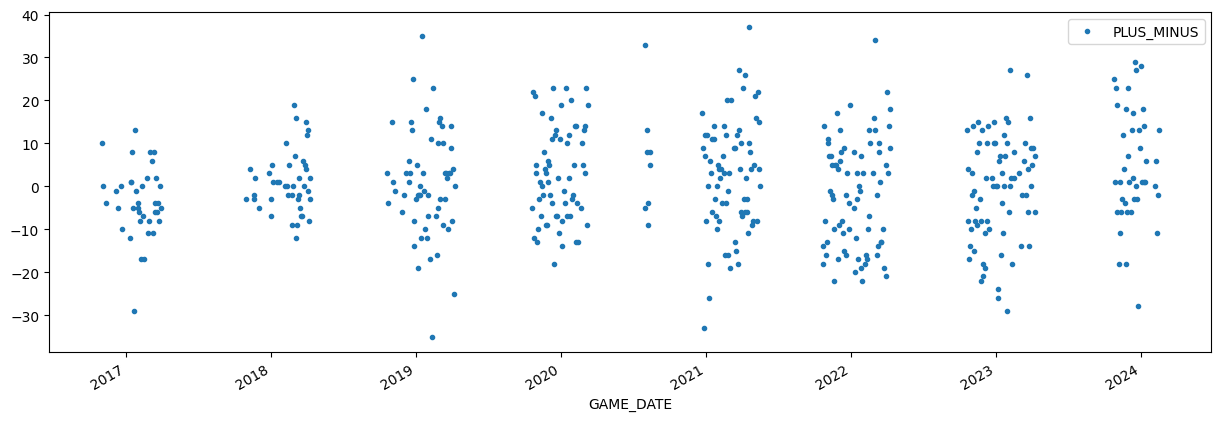

In [12]:
df_player.plot(x='GAME_DATE', y='PLUS_MINUS', style='.', figsize=(15,5))

<AxesSubplot: xlabel='REST'>

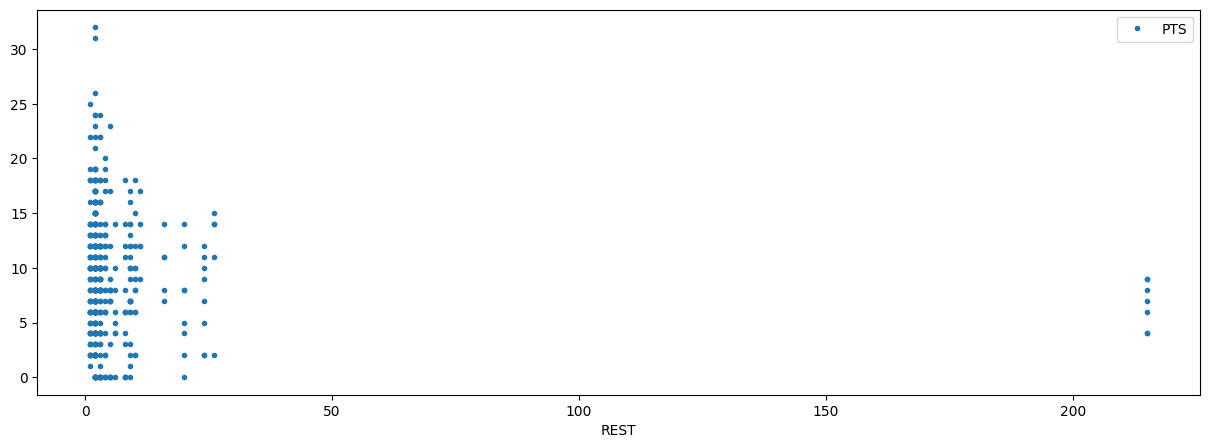

In [13]:
df_player.plot(x='REST', y='PTS', style='.', figsize=(15,5))

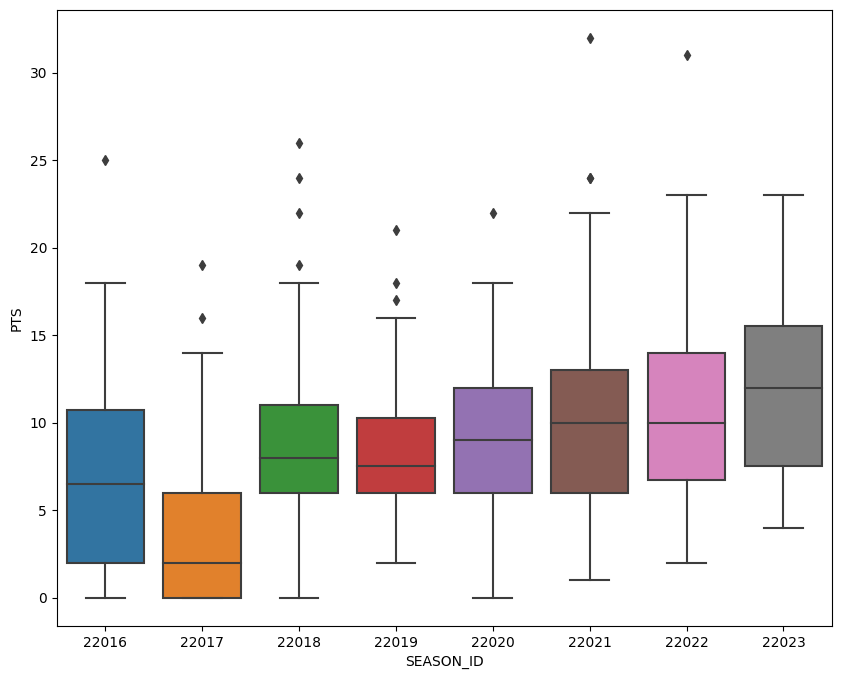

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data= df_player, x='SEASON_ID', y='PTS')
plt.show()

In [234]:
# Save cleaned player data into a pickle file
file_path = '../Data/activePlayerCareerLogData.pickle'
with open(file_path, 'wb') as f:
    pickle.dump(activePlayerCareerLog, f)

### Time Series Feature Engineering

In [236]:
# Load collected player data from pickle file
with open('../Data/activePlayerCareerLogData.pickle', 'rb') as file:
    activePlayerCareerLog = pickle.load(file)

In [237]:
target = 'PTS'
cols_to_drop = ['SEASON_ID', 'Player_ID', 'GAME_DATE', 'OPP', 'TEAM', target + '_target']

In [238]:
# one lag time step
def shift_target(df):
    df[target + '_target'] = df[target].shift(-1)
    df.dropna(inplace=True)
    return df

In [239]:
# rolling window
def recent_average(df, target, games=5):
    shifted_stat = df[target]
    window = shifted_stat.rolling(window=games).mean()
    df['LAST_' + str(games) + '_' + target] = window
    return df

def recent_percentage(df, target1, target2, games=5):
    shifted_stat1 = df[target1]
    shifted_stat2 = df[target2]
    stat_percentage = shifted_stat1 / shifted_stat2
    window = stat_percentage.rolling(window=games).mean()
    df['LAST_' + str(games) + '_' + target1 + '_PCT'] = window
    return df

In [240]:
df_player = activePlayerCareerLog[PLAYER].copy()
df_player = shift_target(df_player)
df_player = recent_average(df_player, target, 3)
df_player = recent_average(df_player, target, 5)
df_player = recent_average(df_player, target, 7)
df_player = recent_average(df_player, 'PLUS_MINUS', 3)
df_player = recent_percentage(df_player, 'FGM', 'FGA', 3)

In [241]:
df_player[features].head(15)

,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,...,PF,PTS,PLUS_MINUS,HOME,REST,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_3_FGM_PCT
0,1,30,12,22,4,7,1,1,1,1,...,1,29,13,1,4,NaN,NaN,NaN,NaN,NaN
1,1,38,10,23,5,9,1,1,1,5,...,4,26,8,0,3,NaN,NaN,NaN,NaN,NaN
2,1,37,7,18,2,6,4,4,0,4,...,2,20,7,1,1,25.000000,NaN,NaN,9.333333,0.456375
3,1,35,10,19,4,6,8,8,1,1,...,1,32,-2,1,3,26.000000,NaN,NaN,4.333333,0.449996
4,1,34,9,18,3,8,2,3,0,4,...,3,23,2,1,2,25.000000,26.0,NaN,2.333333,0.471735
5,1,34,3,17,0,5,2,3,1,6,...,2,8,-8,0,2,21.000000,21.8,NaN,-2.666667,0.400929
6,0,39,11,27,1,7,6,7,0,1,...,3,29,-4,1,3,20.000000,22.4,23.857143,-3.333333,0.361293
7,1,36,11,23,4,9,3,4,0,2,...,3,29,17,0,3,22.000000,24.2,23.857143,1.666667,0.354046
8,1,27,8,17,1,5,2,2,2,1,...,2,19,-5,1,2,25.666667,21.6,22.857143,2.666667,0.452086
9,1,35,10,20,2,4,2,4,2,3,...,3,24,2,1,2,24.000000,21.8,23.428571,4.666667,0.482950


In [242]:
for player in activePlayerCareerLog.values():
    player = shift_target(player)
    player = recent_average(player, target, 3)
    player = recent_average(player, target, 5)
    player = recent_average(player, target, 7)
    player = recent_average(player, 'PLUS_MINUS', 3)
    player = recent_percentage(player, 'FGM', 'FGA', 5)

In [243]:
activePlayerCareerLog['aaron gordon'].head()

,SEASON_ID,Player_ID,GAME_DATE,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,...,HOME,OPP,TEAM,REST,PTS_target,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT
0,22016,203932,2016-10-26,0,35,5,12,2,3,0,...,1,MIA,ORL,4,17.0,NaN,NaN,NaN,NaN,NaN
1,22016,203932,2016-10-28,0,29,6,12,1,2,4,...,0,DET,ORL,2,8.0,NaN,NaN,NaN,NaN,NaN
2,22016,203932,2016-10-29,0,26,3,7,1,3,1,...,0,CLE,ORL,1,7.0,12.333333,NaN,NaN,-14.000000,NaN
3,22016,203932,2016-11-01,1,32,3,10,0,4,1,...,0,PHI,ORL,3,13.0,10.666667,NaN,NaN,-6.666667,NaN
4,22016,203932,2016-11-03,1,31,5,10,1,3,2,...,1,SAC,ORL,2,9.0,9.333333,11.4,NaN,-2.666667,0.429048


### Train / Test Split

In [244]:
df_columns = list(activePlayerCareerLog[PLAYER].columns)
features = df_columns
for col in cols_to_drop:
    features.remove(col)
print(features)

['WL', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'HOME', 'REST', 'LAST_3_PTS', 'LAST_5_PTS', 'LAST_7_PTS', 'LAST_3_PLUS_MINUS', 'LAST_5_FGM_PCT']


In [245]:
# Split players into train and test sets
split_ratio = 0.7
players_train = list(activePlayerCareerLog.keys())[:int(split_ratio * len(activePlayerCareerLog))]
players_test = list(activePlayerCareerLog.keys())[int(split_ratio * len(activePlayerCareerLog)):]
print(len(players_train), len(players_test))

309 133


In [246]:
train = df_player.loc[df_player['SEASON_ID'] < '2022']
test = df_player.loc[df_player['SEASON_ID'] >= '2022']

In [247]:
X_train = pd.concat(activePlayerCareerLog[key][features] for key in players_train)
X_test = pd.concat(activePlayerCareerLog[key][features] for key in players_test)

y_train = pd.concat(activePlayerCareerLog[key][[target + '_target']] for key in players_train)
y_test = pd.concat(activePlayerCareerLog[key][[target + '_target']] for key in players_test)

### Data Normalization and Standardization

In [249]:
norm_scaler = MinMaxScaler(feature_range=(0,1)).set_output(transform='pandas')

X_train_norm = norm_scaler.fit_transform(X_train)
X_test_norm = norm_scaler.fit_transform(X_test)
y_train_norm = norm_scaler.fit_transform(y_train)
y_test_norm = norm_scaler.fit_transform(y_test)

In [250]:
X_train_norm.head()

,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,...,PF,PTS,PLUS_MINUS,HOME,REST,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT
0,0.0,0.241379,0.12,0.097561,0.0,0.0,0.076923,0.1250,0.076923,0.090909,...,0.333333,0.109589,0.574074,0.0,0.003015,NaN,NaN,NaN,NaN,NaN
1,1.0,0.327586,0.20,0.170732,0.0,0.0,0.038462,0.0625,0.076923,0.090909,...,1.000000,0.150685,0.555556,1.0,0.001005,NaN,NaN,NaN,NaN,NaN
2,0.0,0.310345,0.20,0.195122,0.0,0.0,0.000000,0.0625,0.000000,0.181818,...,0.500000,0.136986,0.379630,1.0,0.003015,0.177914,NaN,NaN,0.488038,NaN
3,1.0,0.206897,0.00,0.048780,0.0,0.0,0.000000,0.0000,0.230769,0.090909,...,0.333333,0.000000,0.500000,1.0,0.000000,0.128834,NaN,NaN,0.449761,NaN
4,0.0,0.206897,0.12,0.097561,0.0,0.0,0.153846,0.1875,0.153846,0.181818,...,0.000000,0.136986,0.472222,0.0,0.001005,0.122699,0.149425,NaN,0.406699,0.567857


In [251]:
std_scaler = StandardScaler().set_output(transform="pandas")

X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.fit_transform(X_test)
y_train_std = std_scaler.fit_transform(y_train)
y_test_std = std_scaler.fit_transform(y_test)

In [252]:
print(X_train_std.shape)
X_train_std.head()

(87281, 25)


,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,...,PF,PTS,PLUS_MINUS,HOME,REST,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT
0,-1.028676,-1.105576,-0.443125,-0.901047,-0.856944,-1.16244,0.001276,0.468735,-0.005681,-0.541836,...,0.022163,-0.468911,0.469296,-1.003685,-0.019239,NaN,NaN,NaN,NaN,NaN
1,0.972123,-0.612621,0.152841,-0.414914,-0.856944,-1.16244,-0.382626,-0.174778,-0.005681,-0.541836,...,2.761202,-0.141595,0.299970,0.996329,-0.123950,NaN,NaN,NaN,NaN,NaN
2,-1.028676,-0.711212,0.152841,-0.252870,-0.856944,-1.16244,-0.766528,-0.174778,-0.732713,0.161846,...,0.706923,-0.250700,-1.308630,0.996329,-0.019239,-0.340836,NaN,NaN,-0.294885,NaN
3,0.972123,-1.302759,-1.337074,-1.225136,-0.856944,-1.16244,-0.766528,-0.818291,1.448384,-0.541836,...,0.022163,-1.341753,-0.208009,0.996329,-0.176306,-0.682551,NaN,NaN,-0.663944,NaN
4,-1.028676,-1.302759,-0.443125,-0.901047,-0.856944,-1.16244,0.769079,1.112248,0.721352,0.161846,...,-1.347356,-0.250700,-0.461999,-1.003685,-0.123950,-0.725265,-0.60962,NaN,-1.079135,0.945885


In [254]:
print("Train Shape: X = {} , y = {}".format(X_train.shape, y_train.shape))
print("Test Shape: X = {} , y = {}".format(X_test.shape, y_test.shape))

Train Shape: X = (87281, 25) , y = (87281, 1)
Test Shape: X = (34104, 25) , y = (34104, 1)


In [255]:
X_train.describe()

,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,...,PF,PTS,PLUS_MINUS,HOME,REST,LAST_3_PTS,LAST_5_PTS,LAST_7_PTS,LAST_3_PLUS_MINUS,LAST_5_FGM_PCT
count,87281.000000,87281.000000,87281.000000,87281.000000,87281.000000,87281.000000,87281.000000,87281.000000,87281.000000,87281.000000,...,87281.000000,87281.000000,87281.000000,87281.000000,87281.000000,86663.000000,86047.000000,85431.000000,86663.000000,77318.000000
mean,0.514133,25.213746,4.487082,9.560500,1.326944,3.633884,1.996677,2.543200,1.007814,3.540003,...,1.967633,12.297785,0.456904,0.501839,4.367457,12.326468,12.352963,12.379983,0.464050,0.463715
std,0.499803,10.142954,3.355915,6.171189,1.548470,3.126100,2.604848,3.107959,1.375462,2.842208,...,1.460375,9.165512,11.811585,0.499999,19.100180,7.803810,7.468566,7.303714,7.225627,0.110101
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-56.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-35.666667,0.000000
25%,0.000000,18.000000,2.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,5.000000,-7.000000,0.000000,2.000000,6.333333,6.600000,6.857143,-4.333333,0.395658
50%,1.000000,27.000000,4.000000,9.000000,1.000000,3.000000,1.000000,2.000000,1.000000,3.000000,...,2.000000,11.000000,0.000000,1.000000,2.000000,11.000000,11.000000,11.000000,0.333333,0.458806
75%,1.000000,33.000000,7.000000,13.000000,2.000000,6.000000,3.000000,4.000000,1.000000,5.000000,...,3.000000,18.000000,8.000000,1.000000,3.000000,17.000000,16.800000,16.714286,5.000000,0.525000
max,1.000000,58.000000,25.000000,41.000000,13.000000,23.000000,26.000000,32.000000,13.000000,22.000000,...,6.000000,73.000000,52.000000,1.000000,996.000000,54.333333,52.200000,48.857143,34.000000,1.000000


### Training - XGBoost 

In [203]:
param_grid = {
    #'learning_rate' : [0.1, 0.05],
    'max_depth' : [4, 5, 6],
    #'min_child_weight' : [4, 16],
    #'n_estimators' : [7, 8, 9],
    #'gamma' : [i / 10.0 for i in range(0,5)],
    #'reg_alpha' : [0.01, 0.03, 0.05, 0.07, 0.1]
}

In [256]:
params = {
    'learning_rate' : 0.07,
    'max_depth' : 5,
    'n_estimators' : 90,
    'gamma' : 0,
    'min_child_weight' : 16,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8,
    'reg_alpha' : 0.07
}

In [94]:
model = xgb.XGBRegressor(**params)

xgtrain = xgb.DMatrix(X_train, y_train)
cvresult = xgb.cv(params, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5, metrics='rmse', early_stopping_rounds=50)

cvresult

c:\Users\micha\anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:160: UserWarning: [14:20:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,8.844727,0.014195,8.846270,0.058846
1,8.553766,0.013619,8.556859,0.057810
2,8.294242,0.013190,8.298890,0.056769
3,8.060897,0.012449,8.067467,0.056524
4,7.852893,0.011914,7.861020,0.055939
...,...,...,...,...
85,6.197935,0.007743,6.318289,0.027814
86,6.196966,0.007873,6.318194,0.027786
87,6.196031,0.007825,6.318130,0.027645
88,6.195148,0.007779,6.318227,0.027688


In [205]:
model = xgb.XGBRegressor(**params)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
grid_search.fit(X_train_std, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.07, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=16, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=90,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [4, 5, 6]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [257]:
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

Best Hyperparameters:  {'max_depth': 5}


In [258]:
best_model = xgb.XGBRegressor(**params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=16, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=90, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [259]:
y_pred = best_model.predict(X_test).round()
y_pred = y_pred.reshape(-1, 1)
y_pred.astype(int)

y_test = np.array(y_test).astype(int)

metrics.accuracy_score(y_test, y_pred)

0.06544686840253343

In [260]:
best_model_results = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
best_model_results['Error'] = abs(best_model_results['Actual'] - best_model_results['Predicted'])
best_model_results.describe()

,Actual,Predicted,Error
count,34104.000000,34104.000000,34104.000000
mean,11.891743,11.979738,4.826267
std,8.593998,6.103773,3.979405
min,0.000000,2.000000,0.000000
25%,5.000000,7.000000,2.000000
50%,11.000000,11.000000,4.000000
75%,17.000000,16.000000,7.000000
max,62.000000,38.000000,42.000000


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

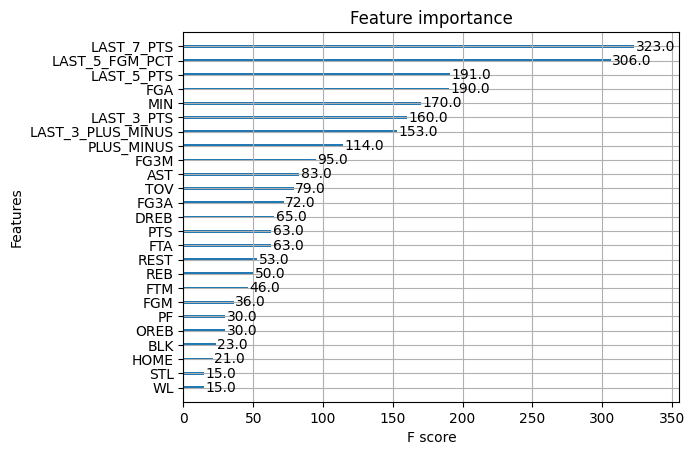

In [261]:
plot_importance(best_model)

<AxesSubplot: title={'center': 'Feature Importance'}>

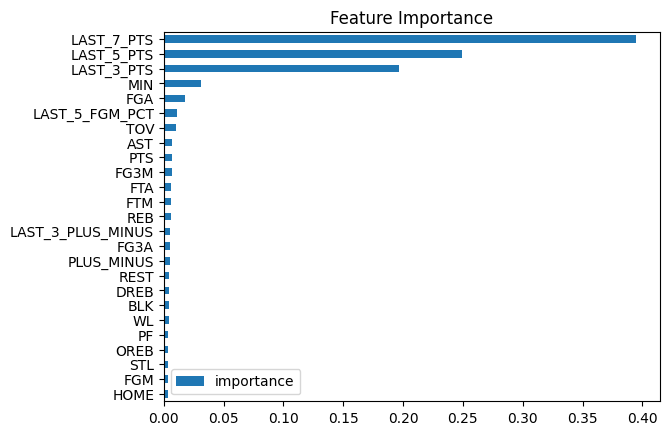

In [263]:
fi = pd.DataFrame(data= best_model.feature_importances_,
                index= best_model.feature_names_in_,
                columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

### Training - XGBoost (standardized)

In [264]:
print(X_train_std.shape)
print(y_train.shape)

(87281, 25)
(87281, 1)


In [265]:
reg_std = xgb.XGBRegressor(**best_params)
reg_std.fit(X_train_std, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

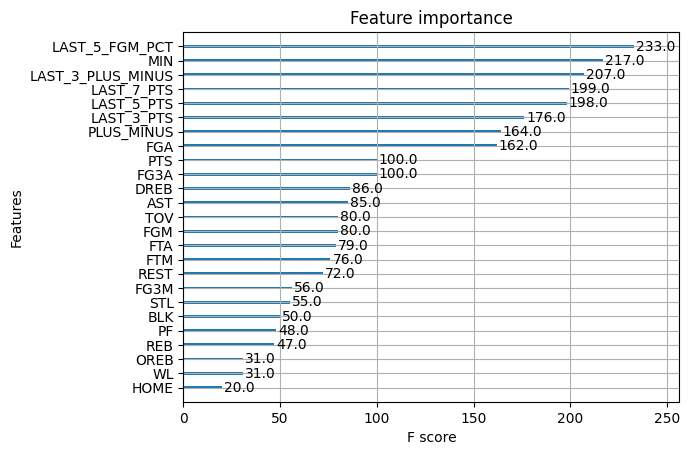

In [266]:
plot_importance(reg_std)

In [267]:
y_pred_std = reg_std.predict(X_test_std).round()
y_pred_std = y_pred_std.reshape(-1, 1)
y_pred_std.astype(int)

metrics.accuracy_score(y_test, y_pred_std)

0.06676636171710064

In [268]:
std_model_results = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred_std.flatten()})
std_model_results['Error'] = abs(std_model_results['Actual'] - std_model_results['Predicted'])
std_model_results.describe()

,Actual,Predicted,Error
count,34104.000000,34104.000000,34104.000000
mean,11.891743,12.176313,4.879105
std,8.593998,6.576420,4.059568
min,0.000000,1.000000,0.000000
25%,5.000000,7.000000,2.000000
50%,11.000000,11.000000,4.000000
75%,17.000000,16.000000,7.000000
max,62.000000,47.000000,42.000000


### Training - XGBoost (normalized)

In [269]:
reg_norm = xgb.XGBRegressor(**best_params)
reg_norm.fit(X_train_norm, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

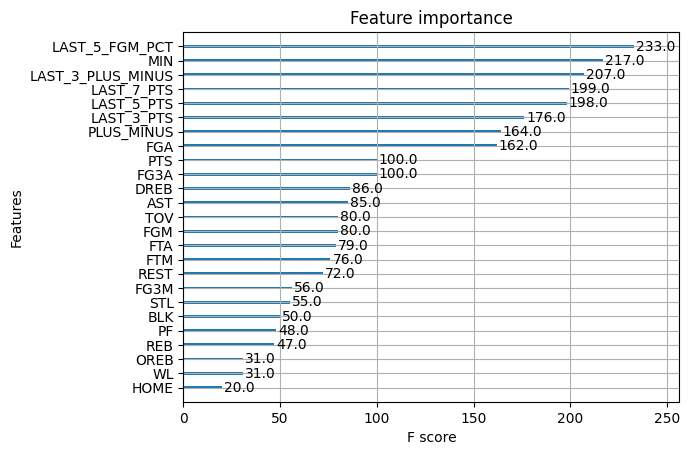

In [270]:
plot_importance(reg_norm)

In [271]:
y_pred_norm = reg_norm.predict(X_test_norm).round()
y_pred_norm = y_pred_norm.reshape(-1, 1)
y_pred_norm.astype(int)

metrics.accuracy_score(y_test, y_pred_norm)

0.06031550551254985

In [272]:
norm_model_results = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred_norm.flatten()})
norm_model_results['Error'] = abs(norm_model_results['Actual'] - norm_model_results['Predicted'])
norm_model_results.describe()

,Actual,Predicted,Error
count,34104.000000,34104.000000,34104.000000
mean,11.891743,13.546827,5.188570
std,8.593998,7.218742,4.209217
min,0.000000,1.000000,0.000000
25%,5.000000,8.000000,2.000000
50%,11.000000,12.000000,4.000000
75%,17.000000,18.000000,7.000000
max,62.000000,52.000000,42.000000


### Individual Player Model

In [585]:
df_player = activePlayerCareerLog[PLAYER]
df_player.head(7)

,SEASON_ID,Player_ID,GAME_DATE,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,...,TOV,PF,PTS,PLUS_MINUS,HOME,OPP,TEAM,REST,PTS_target,LAST_5_PTS
0,22016,202681,2016-10-25,1,30,12,22,4,7,1,...,0,1,29,13,1,NYK,CLE,4,26.0,NaN
1,22016,202681,2016-10-28,1,38,10,23,5,9,1,...,7,4,26,8,0,TOR,CLE,3,20.0,NaN
2,22016,202681,2016-10-29,1,37,7,18,2,6,4,...,1,2,20,7,1,ORL,CLE,1,32.0,NaN
3,22016,202681,2016-11-01,1,35,10,19,4,6,8,...,3,1,32,-2,1,HOU,CLE,3,23.0,NaN
4,22016,202681,2016-11-03,1,34,9,18,3,8,2,...,3,3,23,2,1,BOS,CLE,2,8.0,NaN
5,22016,202681,2016-11-05,1,34,3,17,0,5,2,...,4,2,8,-8,0,PHI,CLE,2,29.0,26.0
6,22016,202681,2016-11-08,0,39,11,27,1,7,6,...,0,3,29,-4,1,ATL,CLE,3,29.0,21.8


In [586]:
df_train = df_player[df_player['GAME_DATE'] < pd.Timestamp('2023-10-01')]
df_test = df_player[df_player['GAME_DATE'] > pd.Timestamp('2022-10-01')]
print(df_train.shape)
print(df_test.shape)

(362, 27)
(92, 27)


In [587]:
X_train_p = df_train[features]
y_train_p = df_train[target + '_target']

X_test_p = df_test[features]
y_test_p = df_test[target + '_target']

In [588]:
X_train_p.head()

,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,...,STL,BLK,TOV,PF,PTS,PLUS_MINUS,WL,HOME,REST,LAST_5_PTS
0,30,12,22,4,7,1,1,1,1,2,...,2,0,0,1,29,13,1,1,4,NaN
1,38,10,23,5,9,1,1,1,5,6,...,0,0,7,4,26,8,1,0,3,NaN
2,37,7,18,2,6,4,4,0,4,4,...,0,2,1,2,20,7,1,1,1,NaN
3,35,10,19,4,6,8,8,1,1,2,...,0,0,3,1,32,-2,1,1,3,NaN
4,34,9,18,3,8,2,3,0,4,4,...,0,0,3,3,23,2,1,1,2,NaN


In [589]:
norm_scaler.fit_transform(X_train_p).head()

,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,...,STL,BLK,TOV,PF,PTS,PLUS_MINUS,WL,HOME,REST,LAST_5_PTS
0,0.608696,0.60,0.65625,0.444444,0.4375,0.058824,0.058824,0.2,0.1,0.181818,...,0.25,0.0,0.000000,0.2,0.483333,0.637681,1.0,1.0,0.428571,NaN
1,0.782609,0.50,0.68750,0.555556,0.5625,0.058824,0.058824,0.2,0.5,0.545455,...,0.00,0.0,1.000000,0.8,0.433333,0.565217,1.0,0.0,0.285714,NaN
2,0.760870,0.35,0.53125,0.222222,0.3750,0.235294,0.235294,0.0,0.4,0.363636,...,0.00,0.5,0.142857,0.4,0.333333,0.550725,1.0,1.0,0.000000,NaN
3,0.717391,0.50,0.56250,0.444444,0.3750,0.470588,0.470588,0.2,0.1,0.181818,...,0.00,0.0,0.428571,0.2,0.533333,0.420290,1.0,1.0,0.285714,NaN
4,0.695652,0.45,0.53125,0.333333,0.5000,0.117647,0.176471,0.0,0.4,0.363636,...,0.00,0.0,0.428571,0.6,0.383333,0.478261,1.0,1.0,0.142857,NaN


In [590]:
metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [ ]:
def modelfit(alg, X_train, y_train, cv_folds=5, early_stopping_rounds=50):
    

In [778]:
param_grid = {
    #'learning_rate' : [0.1, 0.01],
    #'max_depth' : [7, 8, 9],
    #'n_estimators' : [7, 8, 9],
    #'gamma' : [i / 10.0 for i in range(0,5)],
    #'min_child_weight' : [1, 2, 3]
    'reg_alpha' : [1, 0.1, 0.05, 0.01, 0.005, 0.001]
}

In [794]:
params = {
    'learning_rate' : 0.01,
    'max_depth' : 8,
    'n_estimators' : 9,
    'gamma' : 0.4,
    'min_child_weight' : 2
}

In [800]:
model = xgb.XGBRegressor(**params)

xgtrain = xgb.DMatrix(X_train_p, y_train_p)
cvresult = xgb.cv(params, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5, metrics='rmse', early_stopping_rounds=50)

cvresult

c:\Users\micha\anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:160: UserWarning: [15:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,8.744190,0.121839,8.783340,0.485175
1,8.704535,0.122243,8.787647,0.488197
2,8.665362,0.122658,8.791448,0.491006
3,8.626707,0.122471,8.796102,0.494295
4,8.589563,0.122817,8.801243,0.497883
5,8.552344,0.124843,8.806885,0.498776
6,8.515440,0.124820,8.811364,0.501778
7,8.478112,0.124434,8.817461,0.504460
8,8.442678,0.127338,8.822435,0.505615


In [795]:
p_model = xgb.XGBRegressor(**params)

p_grid_search = GridSearchCV(p_model, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
p_grid_search.fit(std_scaler.fit_transform(X_train_p), y_train_p)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.4,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.01, ma...ne,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=8, max_leaves=None,
                                    min_child_weight=2, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=9,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'reg_alpha': [1, 0.1, 0.05, 0.01, 0.005, 0.001]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [791]:
p_grid_search.best_index_

3

In [792]:
p_grid_search.best_score_

-8.775826176833416

In [796]:
p_best_params = p_grid_search.best_params_
print("Best Hyperparameters: ", p_best_params)

Best Hyperparameters:  {'reg_alpha': 0.01}


In [797]:
best_model_player = xgb.XGBRegressor(**params)
best_model_player.fit(std_scaler.fit_transform(X_train_p), y_train_p)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=9, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [798]:
best_model_player.feature_names_in_

array(['MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'WL',
       'HOME', 'REST', 'LAST_5_PTS'], dtype='<U10')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

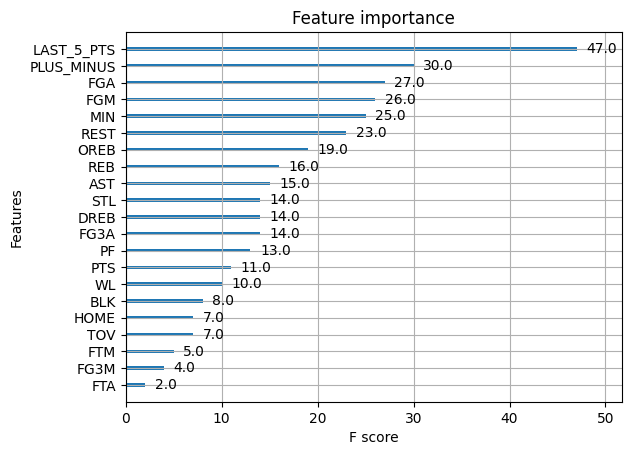

In [799]:
plot_importance(best_model_player)

<AxesSubplot: title={'center': 'Feature Importance'}>

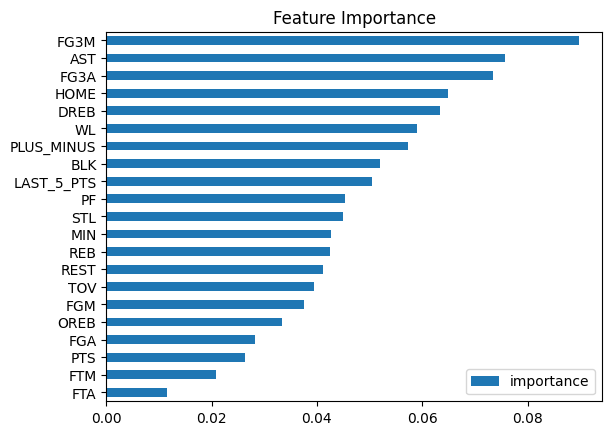

In [788]:
fi = pd.DataFrame(data= best_model_player.feature_importances_,
                index= best_model_player.feature_names_in_,
                columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

In [789]:
p_y_pred = best_model_player.predict(std_scaler.fit_transform(X_test_p)).round()
p_y_pred = p_y_pred.reshape(-1, 1)
p_y_pred.astype(int)

p_y_test = np.array(y_test_p).astype(int)
print(p_y_pred)
metrics.accuracy_score(p_y_test, p_y_pred)

[[26.]
 [25.]
 [26.]
 [26.]
 [27.]
 [26.]
 [26.]
 [26.]
 [26.]
 [25.]
 [25.]
 [25.]
 [25.]
 [26.]
 [26.]
 [26.]
 [25.]
 [25.]
 [26.]
 [26.]
 [26.]
 [25.]
 [25.]
 [26.]
 [26.]
 [25.]
 [27.]
 [25.]
 [26.]
 [25.]
 [25.]
 [25.]
 [25.]
 [26.]
 [26.]
 [25.]
 [25.]
 [26.]
 [26.]
 [25.]
 [25.]
 [25.]
 [27.]
 [25.]
 [25.]
 [26.]
 [26.]
 [26.]
 [26.]
 [26.]
 [25.]
 [26.]
 [25.]
 [25.]
 [26.]
 [26.]
 [25.]
 [27.]
 [26.]
 [26.]
 [25.]
 [25.]
 [25.]
 [26.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [26.]
 [25.]
 [25.]
 [27.]
 [26.]
 [26.]
 [26.]
 [27.]
 [25.]
 [26.]
 [25.]
 [25.]
 [26.]
 [26.]
 [26.]
 [26.]
 [25.]
 [26.]
 [26.]
 [26.]]


0.03260869565217391

In [606]:
print(p_y_pred.shape)
print(y_test_p.shape)

(92, 1)
(92,)
